In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:

from sklearn.model_selection import train_test_split # to split the data into two parts
# from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score


In [4]:
!pip install keras

In [5]:
!pip install tensorflow

In [6]:

import keras
from keras.layers import Dense
from keras.models import Sequential
#from keras.utils import to_categorical
#from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout


In [7]:


import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")

%matplotlib inline

In [8]:
import mlflow

from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open(".mlflow_uri").read().strip()

"""
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run()
run = mlflow.active_run()

or parameters of the model (fit_intercept for Linear Regression model)
mlflow_params = {
      "altitude_low_meters_mean": altitude_low_meters_mean,
      "altitude_high_meters_mean": altitude_high_meters_mean,
      "altitude_mean_log_mean": altitude_mean_log_mean,
      "fit_intercept": True,
  }


# logging params to mlflow
#mlflow.log_params(params)
# setting tags
mlflow.set_tag("model", "XGBoost")
mlflow.set_tag("features", "imbalance price")
# logging metrics
# mlflow.log_metric("train-" + "RMSE", rmse_train)
# mlflow.log_metric("test-" + "RMSE", rmse_test)
# mlflow.log_metric("train-" + "R2", rsquared_train)
# mlflow.log_metric("test-" + "R2", rsquared_test)
# end run
# mlflow.end_run()
"""

'\n# setting the MLFlow connection and experiment\nmlflow.set_tracking_uri(TRACKING_URI)\nmlflow.set_experiment(EXPERIMENT_NAME)\nmlflow.start_run()\nrun = mlflow.active_run()\n\nor parameters of the model (fit_intercept for Linear Regression model)\nmlflow_params = {\n      "altitude_low_meters_mean": altitude_low_meters_mean,\n      "altitude_high_meters_mean": altitude_high_meters_mean,\n      "altitude_mean_log_mean": altitude_mean_log_mean,\n      "fit_intercept": True,\n  }\n\n\n# logging params to mlflow\n#mlflow.log_params(params)\n# setting tags\nmlflow.set_tag("model", "XGBoost")\nmlflow.set_tag("features", "imbalance price")\n# logging metrics\n# mlflow.log_metric("train-" + "RMSE", rmse_train)\n# mlflow.log_metric("test-" + "RMSE", rmse_test)\n# mlflow.log_metric("train-" + "R2", rsquared_train)\n# mlflow.log_metric("test-" + "R2", rsquared_test)\n# end run\n# mlflow.end_run()\n'

In [9]:
train = pd.read_csv('../data/train.csv')
train.head()

,datetime,1
0,2013-12-31 23:00:00,917.118
1,2014-01-01 00:00:00,1264.266
2,2014-01-01 01:00:00,746.810
3,2014-01-01 02:00:00,-15.512
4,2014-01-01 03:00:00,-36.904


In [10]:
train = train.rename(columns={'1':'imb_price'})
train.head()

,datetime,imb_price
0,2013-12-31 23:00:00,917.118
1,2014-01-01 00:00:00,1264.266
2,2014-01-01 01:00:00,746.810
3,2014-01-01 02:00:00,-15.512
4,2014-01-01 03:00:00,-36.904


In [11]:
test = pd.read_csv('../data/test.csv')
test.head()

,datetime,1
0,2019-03-05 06:00:00,-349.8990
1,2019-03-05 07:00:00,372.9630
2,2019-03-05 08:00:00,371.4125
3,2019-03-05 09:00:00,817.3485
4,2019-03-05 10:00:00,638.5965


In [12]:
test = test.rename(columns={'1':'imb_price'})
test.head()

,datetime,imb_price
0,2019-03-05 06:00:00,-349.8990
1,2019-03-05 07:00:00,372.9630
2,2019-03-05 08:00:00,371.4125
3,2019-03-05 09:00:00,817.3485
4,2019-03-05 10:00:00,638.5965


In [13]:
# shift function for one-lagged series for training data set

train['shift1'] = train['imb_price'].shift(-1)
train.tail()

,datetime,imb_price,shift1
45338,2019-03-05 01:00:00,147.278,-28.272
45339,2019-03-05 02:00:00,-28.272,-201.291
45340,2019-03-05 03:00:00,-201.291,83.710
45341,2019-03-05 04:00:00,83.710,-102.683
45342,2019-03-05 05:00:00,-102.683,NaN


In [14]:
# shift function for one-lagged series for test data set

test['shift1'] = test['imb_price'].shift(-1)
test.tail()

,datetime,imb_price,shift1
19428,2021-05-22 18:00:00,-1.051667,14.628167
19429,2021-05-22 19:00:00,14.628167,30.308000
19430,2021-05-22 20:00:00,30.308000,164.239000
19431,2021-05-22 21:00:00,164.239000,298.170000
19432,2021-05-22 22:00:00,298.170000,NaN


In [15]:
# removing the last line in the training data set
train = train.dropna()
train.tail()

,datetime,imb_price,shift1
45337,2019-03-05 00:00:00,-328.8805,147.278
45338,2019-03-05 01:00:00,147.2780,-28.272
45339,2019-03-05 02:00:00,-28.2720,-201.291
45340,2019-03-05 03:00:00,-201.2910,83.710
45341,2019-03-05 04:00:00,83.7100,-102.683


In [16]:
# removing the last line in the test data set
test = test.dropna()
test.tail()

,datetime,imb_price,shift1
19427,2021-05-22 17:00:00,-16.731500,-1.051667
19428,2021-05-22 18:00:00,-1.051667,14.628167
19429,2021-05-22 19:00:00,14.628167,30.308000
19430,2021-05-22 20:00:00,30.308000,164.239000
19431,2021-05-22 21:00:00,164.239000,298.170000


In [17]:
# removing datetime column time in train data set in order to convert it into a non-time series problem
train = train.drop('datetime', axis=1)
train.head()

,imb_price,shift1
0,917.118,1264.266
1,1264.266,746.810
2,746.810,-15.512
3,-15.512,-36.904
4,-36.904,360.392


In [18]:
# removing datetime column time in test data set in order to convert it into a non-time series problem
test = test.drop('datetime', axis=1)
test.head()

,imb_price,shift1
0,-349.8990,372.9630
1,372.9630,371.4125
2,371.4125,817.3485
3,817.3485,638.5965
4,638.5965,-206.9860


In [19]:
scaler = MinMaxScaler()

In [20]:
train = scaler.fit_transform(train)

In [21]:
test = scaler.transform(test)

In [22]:
train.shape

(45342, 2)

In [23]:
train_X, train_y = train[:,[0]], train[:,[1]]

In [24]:
test_X, test_y = test[:,[0]], test[:,[1]]

In [25]:
train_X.shape

(45342, 1)

In [26]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(45342, 1, 1) (45342, 1) (19432, 1, 1) (19432, 1)


In [27]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

2021-11-16 20:59:41.489880: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/20
648/648 - 3s - loss: 0.0116 - val_loss: 0.0034 - 3s/epoch - 5ms/step
Epoch 2/20
648/648 - 1s - loss: 0.0036 - val_loss: 0.0034 - 1s/epoch - 2ms/step
Epoch 3/20
648/648 - 1s - loss: 0.0035 - val_loss: 0.0034 - 1s/epoch - 2ms/step
Epoch 4/20
648/648 - 1s - loss: 0.0034 - val_loss: 0.0035 - 1s/epoch - 2ms/step
Epoch 5/20
648/648 - 1s - loss: 0.0034 - val_loss: 0.0037 - 1s/epoch - 2ms/step
Epoch 6/20
648/648 - 1s - loss: 0.0033 - val_loss: 0.0038 - 1s/epoch - 2ms/step
Epoch 7/20
648/648 - 1s - loss: 0.0033 - val_loss: 0.0038 - 1s/epoch - 2ms/step
Epoch 8/20
648/648 - 1s - loss: 0.0032 - val_loss: 0.0037 - 1s/epoch - 2ms/step
Epoch 9/20
648/648 - 1s - loss: 0.0032 - val_loss: 0.0037 - 1s/epoch - 2ms/step
Epoch 10/20
648/648 - 1s - loss: 0.0031 - val_loss: 0.0038 - 1s/epoch - 2ms/step
Epoch 11/20
648/648 - 1s - loss: 0.0031 - val_loss: 0.0037 - 1s/epoch - 2ms/step
Epoch 12/20
648/648 - 1s - loss: 0.0031 - val_loss: 0.0036 - 1s/epoch - 2ms/step
Epoch 13/20
648/648 - 1s - loss: 0.00

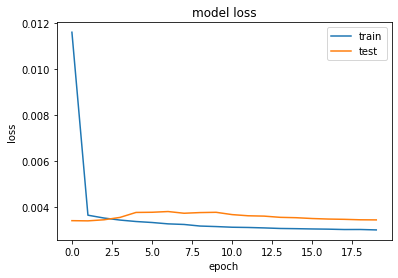

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [39]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y)), 1)
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 401.518


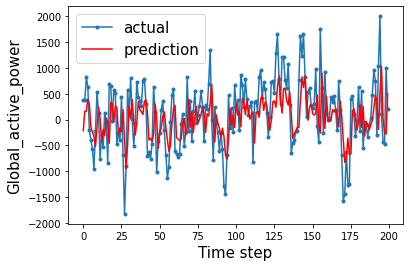

In [40]:
## first 200 time steps, every step is one hour
aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()